In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
%load_ext autoreload
%autoreload 2

## Load the Data and plot the number of ratings per movie and user

number of items: 10000, number of users: 1000
shape of dataset: (10000, 1000)


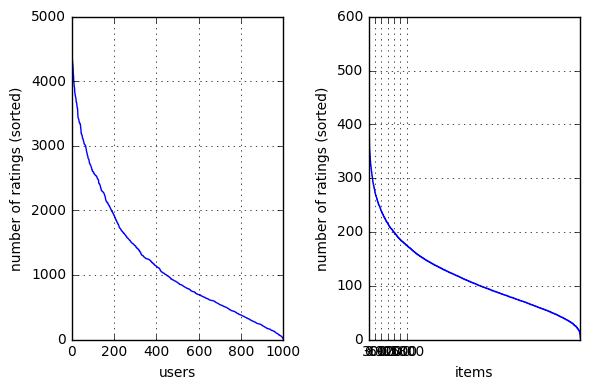

min # of items per user = 8, min # of users per item = 3.


In [6]:
from helpers import load_data, preprocess_data
from plots import plot_raw_data


path_dataset = "../data/data_train.csv"
subset = [100, 101]
#ratings = load_data(path_dataset, subset)
ratings = load_data(path_dataset)
print("shape of dataset:",ratings.shape)
#print(ratings)
#print( ratings[0,9])
#print( ratings[0:5,0:5])
#ratings

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Run to estimate model

In [7]:
import our_helpers as ohe


print("splitting data")
valid_ratings, train, test = ohe.split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)
np.random.seed(600)

train_errors, test_errors, a, b = ohe.ALS(train, test,1000, 0.08, 0.065, 1e-4, [0, 0], 35)

full_ratings = np.dot( train_errors.transpose(), test_errors)

nz_rows, nz_cols = test.nonzero()
nz_test = list( zip(nz_rows, nz_cols))

full_ratings_b = ohe.bias_correction(full_ratings, ratings)
print(compute_error2(test, full_ratings_b, nz_test) )


Percentage of nz train data:  0.8998, percentage of nz test data:  0.1002


KeyboardInterrupt: 

In [74]:
# Check performance by plotting train and test errors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(rng), train_errors, marker='o', label='Training Data');
plt.plot(range(rng), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.savefig("../results/test_train_rmse")
plt.show()

NameError: name 'train_errors' is not defined

### Create Sumbmissions

In [33]:
from our_helpers import create_submission
path_output = "submission.csv"

create_submission(path_output, full_ratings_b)

number of items: 10000, number of users: 1000


# test ALT